# MNIST NEURAL NWTWORK WITH K-MEANS

### Initial Settings (import and variables)

In [1]:
import numpy as np
import time
import math
import struct
from matplotlib import pyplot
import matplotlib as mpl
import datetime as dt
from sklearn.cluster import KMeans
from sklearn.datasets.samples_generator import make_blobs
from sklearn.metrics import pairwise_distances_argmin_min

In [2]:
DATA_PATH = 'data/mnist/'

IMAGES_TRAIN_NAME = 'train-images.idx3-ubyte'
LABELS_TRAIN_NAME = 'train-labels.idx1-ubyte'
IMAGES_TEST_NAME = 't10k-images.idx3-ubyte'
LABELS_TEST_NAME = 't10k-labels.idx1-ubyte'

RANDOM_SEED = 42
N_CLASSES = 10
N_FEATURES = 28 * 28

### Support Functions for Loading and Showig Data

In [3]:
def timing(f):
    def wrap(*args):
        time1 = time.time()
        ret = f(*args)
        time2 = time.time()
        print('%s function took %0.2f ms' % (f.__name__, (time2-time1)*1000.0))
        return ret
    return wrap

def load_data(one_hot=True, reshape=None, validation_size=10000):
    x_tr = load_images(DATA_PATH+IMAGES_TRAIN_NAME)
    y_tr = load_labels(DATA_PATH+LABELS_TRAIN_NAME)
    x_te = load_images(DATA_PATH+IMAGES_TEST_NAME)
    y_te = load_labels(DATA_PATH+LABELS_TEST_NAME)

    x_tr = x_tr[:-validation_size]
    y_tr = y_tr[:-validation_size]

    if one_hot:
        y_tr, y_te = [to_one_hot(y) for y in (y_tr, y_te)]

    if reshape:
        x_tr, x_te = [x.reshape(*reshape) for x in (x_tr, x_te)]

    return x_tr, y_tr, x_te, y_te

def load_images(filename):
    with open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    return data.reshape(-1, 28 * 28) / np.float32(256)

def load_labels(filename):
    with open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
    return data

def to_one_hot(labels, num_classes=10):
    return np.eye(num_classes)[labels]

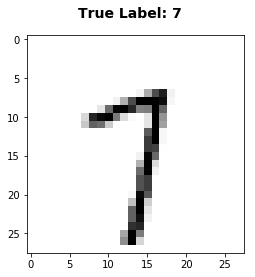

In [4]:
def show_digit(images,labels,idx):
    image = np.array_split((images[idx] * 255).astype(np.uint8),28)
    fig = pyplot.figure()
    title = 'True Label: '+str(np.where(labels[idx] == 1.)[0][0])
    fig.suptitle(title, fontsize=14, fontweight='bold')
    ax = fig.add_subplot(1,1,1)
    imgplot = ax.imshow(image, cmap=mpl.cm.Greys)
    imgplot.set_interpolation('nearest')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    pyplot.show()
    
trX, trY, teX, teY = load_data()
show_digit(trX,trY,42)

### 1 Layer Neural Network

In [5]:
class Neural_Network:

    def __init__(self, neurons=64, features=50, classes=10, epochs=50, learning_rate=0.1, batches=20, random_seed=None, train_img=None, train_lbl=None, test_img=None, test_lbl=None):
        if random_seed:
            self.random_seed = np.random.seed(random_seed)
        self.weights = [np.random.randn(*w) * 0.1 for w in [(features, neurons), (neurons, classes)]]
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.batches = batches
        self.trX = train_img
        self.trY = train_lbl
        self.teX = test_img
        self.teY = test_lbl
    
    def _feed_forward(self, X, weights):
        a = [X]
        for w in weights:
            a.append(np.maximum(a[-1].dot(w),0))
        return a

    def _grads(self, X, Y, weights):
        grads = np.empty_like(weights)
        a = self._feed_forward(X, weights)
        delta = a[-1] - Y
        grads[-1] = a[-2].T.dot(delta)
        for i in range(len(a)-2, 0, -1):
            delta = (a[i] > 0) * delta.dot(weights[i].T)
            grads[i-1] = a[i-1].T.dot(delta)
        return grads / len(X)

    def train(self):
        
        self.start_time = dt.datetime.now()
        print('-- Training Session Start (%s) --' % (self.start_time))
        print('\nEpochs: %d\nLearning Rate: %.3f\nBatches Size: %d\n' % (self.epochs,self.learning_rate,self.batches))
        
        for i in range(self.epochs):

            for j in range(0, len(self.trX), self.batches):
                X, Y = self.trX[j:j+self.batches], self.trY[j:j+self.batches]
                self.weights -= self.learning_rate * self._grads(X, Y, self.weights)
            prediction = np.argmax(self._feed_forward(self.teX, self.weights)[-1], axis=1)

            if i == 0 or (i+1) % 10 == 0:
                diff = dt.datetime.now() - self.start_time
                eta = divmod(diff.days * 86400 + diff.seconds, 60)
                accuracy = np.mean(prediction == np.argmax(teY, axis=1))
                epoch4print = str(i+1).zfill(len(str(self.epochs)))
                print('Epoch %s: accuracy %f in %dm%ds' % ((epoch4print),accuracy,eta[0],eta[1]))
                
        print('\nResult: %f in %dm%ds\n' % (accuracy,eta[0],eta[1]))
        print('-- Training Session End (%s) --' % (dt.datetime.now()))
        
    def getWeights(self):
        return self.weights

In [6]:
nn = Neural_Network(neurons=100,
                    epochs=100,
                    learning_rate=0.001,
                    batches=25,
                    features=N_FEATURES,
                    classes=N_CLASSES,
                    random_seed=RANDOM_SEED,
                    train_img = trX,
                    train_lbl = trY,
                    test_img = teX,
                    test_lbl = teY)

nn.train()

-- Training Session Start (2018-05-16 19:45:48.464853) --

Epochs: 100
Learning Rate: 0.001
Batches Size: 25

Epoch 001: accuracy 0.630200 in 0m1s
Epoch 010: accuracy 0.879500 in 0m13s
Epoch 020: accuracy 0.908400 in 0m26s
Epoch 030: accuracy 0.920100 in 0m39s
Epoch 040: accuracy 0.928100 in 0m52s
Epoch 050: accuracy 0.933500 in 1m5s
Epoch 060: accuracy 0.937100 in 1m18s
Epoch 070: accuracy 0.941200 in 1m31s
Epoch 080: accuracy 0.944000 in 1m45s
Epoch 090: accuracy 0.946100 in 1m58s
Epoch 100: accuracy 0.947600 in 2m11s

Result: 0.947600 in 2m11s

-- Training Session End (2018-05-16 19:47:59.714412) --


### Centroid Functions

In [7]:
def nearest_centroid_index(centers,value):
    centers = np.asarray(centers)
    idx = (np.abs(centers - value)).argmin()
    return idx

def nearest_centroid(centers,value):
    centers = np.asarray(centers)
    idx = (np.abs(centers - value)).argmin()
    return centers[idx]

### 1 Layer Neural Network with K_MEANS

In [8]:
class Neural_Network_KMeans:

    def __init__(self, neurons=64, features=50, classes=10, epochs=50, learning_rate=0.1, batches=20, k_means=None, random_seed=None, train_img=None, train_lbl=None, test_img=None, test_lbl=None):
        if random_seed:
            self.random_seed = np.random.seed(random_seed)
        self.k_means = k_means
        self.weights = [np.random.randn(*w) * 0.1 for w in [(features, neurons), (neurons, classes)]]
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.batches = batches
        self.trX = train_img
        self.trY = train_lbl
        self.teX = test_img
        self.teY = test_lbl
    
    def _feed_forward(self, X, weights):
        a = [X]
        for w in weights:
            a.append(np.maximum(a[-1].dot(w),0))
        return a

    def _grads(self, X, Y, weights):
        grads = np.empty_like(weights)
        a = self._feed_forward(X, weights)
        delta = a[-1] - Y
        grads[-1] = a[-2].T.dot(delta)
        for i in range(len(a)-2, 0, -1):
            delta = (a[i] > 0) * delta.dot(weights[i].T)
            grads[i-1] = a[i-1].T.dot(delta)
        return grads / len(X)
    
    def _redefine_weights(self,centers,weights):
        for w in weights:
            for i, row in enumerate(w):
                for j, col in enumerate(row):
                    w[i,j] = nearest_centroid(centers,w[i,j])
        return weights

    def train(self):
        
        self.weights = self._redefine_weights(self.k_means.cluster_centers_,self.weights)
        
        self.start_time = dt.datetime.now()
        print('-- Training Session Start (%s) --' % (self.start_time))
        print('\nEpochs: %d\nLearning Rate: %.3f\nBatches Size: %d\nClusters: %d\n' % (self.epochs,self.learning_rate,self.batches,len(self.k_means.cluster_centers_)))
        
        for i in range(self.epochs):

            for j in range(0, len(self.trX), self.batches):
                X, Y = self.trX[j:j+self.batches], self.trY[j:j+self.batches]
                self.weights -= self.learning_rate * self._grads(X, Y, self.weights)
            self.weights = self._redefine_weights(self.k_means.cluster_centers_,self.weights)
            prediction = np.argmax(self._feed_forward(self.teX, self.weights)[-1], axis=1)

            if i == 0 or (i+1) % 10 == 0:
                diff = dt.datetime.now() - self.start_time
                eta = divmod(diff.days * 86400 + diff.seconds, 60)
                accuracy = np.mean(prediction == np.argmax(teY, axis=1))
                epoch4print = str(i+1).zfill(len(str(self.epochs)))
                print('Epoch %s: accuracy %f in %dm%ds' % ((epoch4print),accuracy,eta[0],eta[1]))
                
        print('\nResult: %f in %dm%ds\n' % (accuracy,eta[0],eta[1]))
        print('-- Training Session End (%s) --' % (dt.datetime.now()))
        
    def getWeights(self):
        return self.weights

### Settings for K-MEANS

In [9]:
N_CLUSTER = 40

kmeans = KMeans(n_clusters=N_CLUSTER,random_state=RANDOM_SEED)
nn_weights = nn.getWeights()
weights_1D_array = np.append(np.hstack(nn_weights[0]),np.hstack(nn_weights[1]))
kmeans.fit(weights_1D_array.reshape(-1,1))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=40, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [10]:
nn_km = Neural_Network_KMeans(neurons=100,
                              epochs=50,
                              learning_rate=0.01,
                              batches=15,
                              features=N_FEATURES,
                              classes=N_CLASSES,
                              k_means = kmeans,
                              random_seed=RANDOM_SEED,
                              train_img = trX,
                              train_lbl = trY,
                              test_img = teX,
                              test_lbl = teY)

nn_km.train()

-- Training Session Start (2018-05-16 19:48:10.327786) --

Epochs: 50
Learning Rate: 0.010
Batches Size: 15
Clusters: 40

Epoch 01: accuracy 0.897200 in 0m2s
Epoch 10: accuracy 0.941400 in 0m22s
Epoch 20: accuracy 0.944500 in 0m43s
Epoch 30: accuracy 0.944300 in 1m5s
Epoch 40: accuracy 0.944600 in 1m27s
Epoch 50: accuracy 0.944600 in 1m49s

Result: 0.944600 in 1m49s

-- Training Session End (2018-05-16 19:50:00.083291) --


### TEST FOR REPLACE WEIGHTS WITH INDEX IN CENTERS

In [12]:
def redefine_weights(centers,weights):
        arr_ret = np.empty_like(weights)
        for k,w in enumerate(weights):
            arr_int = np.empty_like(w)
            for i, row in enumerate(w):
                for j, col in enumerate(row):
                    arr_int[i,j] = nearest_centroid_index(centers,w[i,j])
            arr_ret[k] = arr_int
        return arr_ret

@timing    
def do_work():
    a = [trX[1:15]]
    for w in redefine_weights(kmeans.cluster_centers_,nn_weights):
        w_list = [[kmeans.cluster_centers_[int(y)][0] for y in x] for x in w]
        a.append(np.maximum(a[-1].dot(w_list),0))
    return a

@timing
def do_little():
    for w in redefine_weights(kmeans.cluster_centers_,nn_weights):
        w_list = [[kmeans.cluster_centers_[int(y)][0] for y in x] for x in w]

do_work()
do_little()
# FUNZIONAAAAAAAAA

do_work function took 291.30 ms
do_little function took 284.05 ms
